2023-10-23 12:53:46.072603: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 12:53:46.074363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 12:53:46.105113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 12:53:46.105610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 12:53:47.096623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              20800     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
114/114 [==============================] - 2s 5ms/step - loss: 0.0087 - val_loss: 0.0328
Epoch 2/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0348
Epoch 3/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0335
Epoch 4/50
114/114 [==============================] - 0s 3ms/step - loss: 0.0

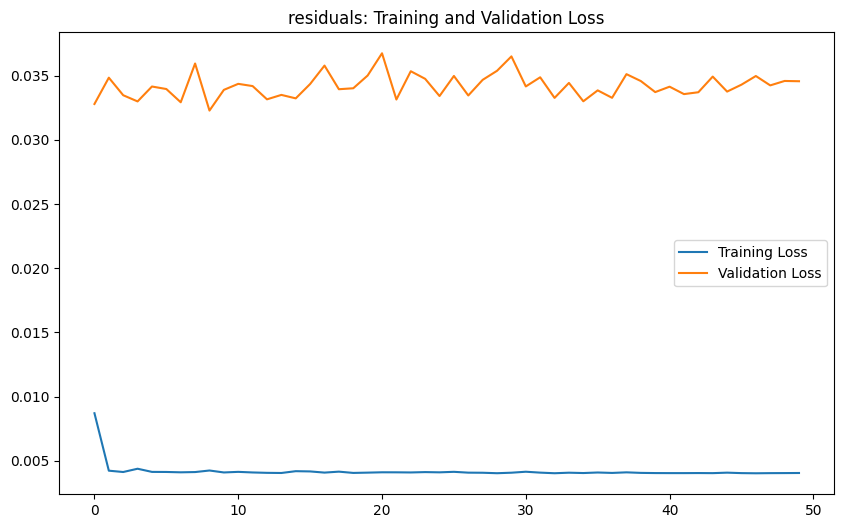

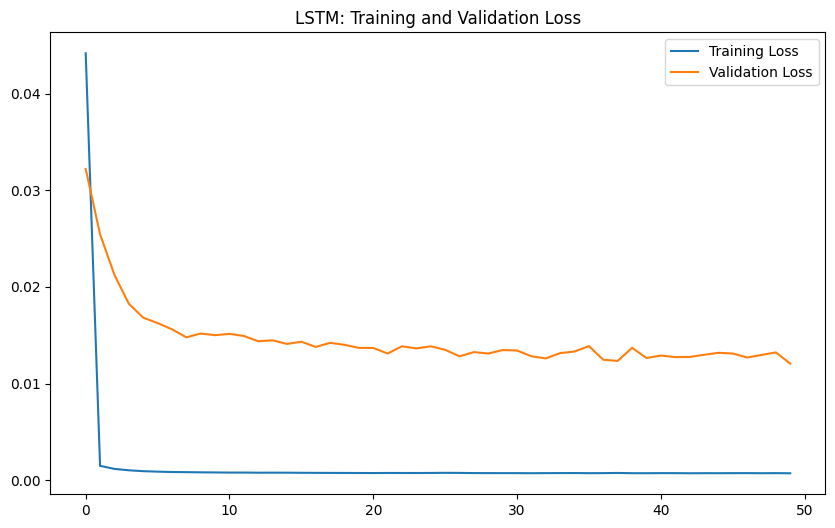

6/6 [==============================] - 0s 1ms/step


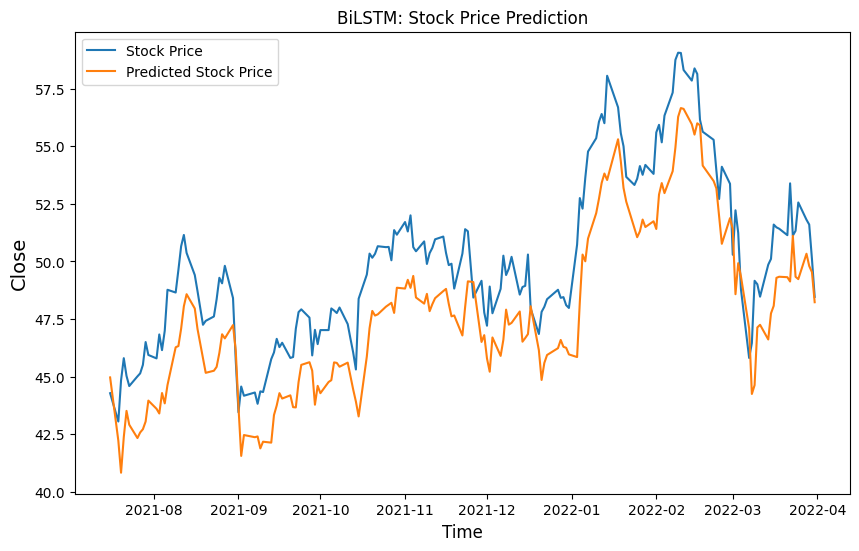

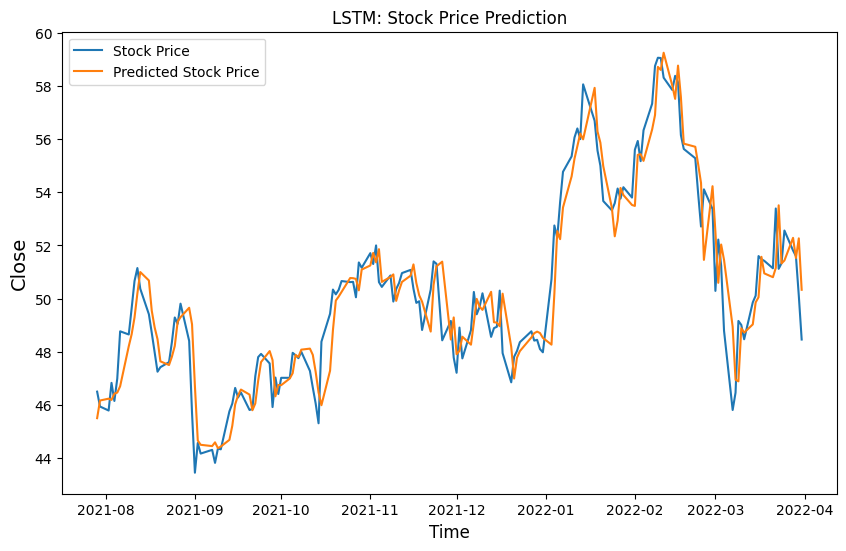

MSE: 6.34752
RMSE: 2.51943
MAE: 2.31370
R2: 0.49874
MSE: 1.28763
RMSE: 1.13474
MAE: 0.85958
R2: 0.88790


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from numpy.random import seed
from utils import *
from model import lstm

# GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50
# ====================================
#      model type：
#            1. single-layer LSTM
#            2. multi-layer LSTM
#            3. bidirectional LSTM
# ====================================
model_type = 3

yuan_data = pd.read_csv('./WFC.csv')  
yuan_data.index = pd.to_datetime(yuan_data['Date']) 
yuan_data = yuan_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]

data = pd.read_csv('./ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['Date'])
data = data.drop('Date', axis=1)
# data = pd.merge(data, yuan_data, on='trade_date') 

Lt = pd.read_csv('./ARIMA.csv')
idx = 3658
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)

model, yuan_model = lstm(model_type,X_train,yuan_X_train)
print(model.summary())
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam,
              loss='mse')
yuan_model.compile(optimizer=adam,
                   loss='mse')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)
yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=n_epochs,
                              validation_data=(yuan_X_test, yuan_y_test),
                              validation_freq=1)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'Date': yuan_data.index[idx+10:],
    'Close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['Date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'Date': yuan_data.index[idx+10:],
    'Close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['Date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = {
    'Date': data.index[idx+10:],
    'Close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

predicted_stock_price1 = predicted_stock_price1.set_index(['Date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('Date')['Close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['Date']) 
finalpredicted_stock_price = finalpredicted_stock_price.drop(['Date'], axis=1)

plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2021-07-16':, 'Close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['Close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['Close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['Close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

yhat = yuan_data.loc['2021-07-16':, 'Close']
evaluation_metric(finalpredicted_stock_price['Close'],yhat)

yhatL = yuan_real_stock_price1['Close']
evaluation_metric(yuan_predicted_stock_price1['Close'],yhatL)